# Capstone Project - The Battle of Neighborhoods (Week 2)

## Introduction

The problem that I am going to takle is to compare the neighbourhoods of Toronto and  New York (restricted to Manhattan) and try to identify clusters of similar ones across both cities. 

The idea behind that is for someone moving from one city to the other to be able to find a similar neighbourhood to live in.

The audience is therefore someone moving from New York (Manhattan) to Toronto or from Toronto to New York (Manhattan) and looking for a similar neighbourhoods to live in.

## Data

The data that will be used for this analysis is the same one used for the New York and Toronto projects but the idea is to analyse them together.

In detail, the data used will be:

- A dataset of NY that contains the 5 boroughs and the neighborhoods that exist in each borough (306 in total) as well as the the latitude and longitude coordinates of each neighborhood.
    This dataset can be found at the following address: https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
    
- A similar dataset will be constructed for Toronto using the data from the wikipedia page https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M and a csv file available here http://cocl.us/Geospatial_data for the latitudes and longitudes

- With those datasets, the top 100 venues for each neighborhood will be retrieved using the Foursquare API and the clustering analysis will be done using the type of venues present in each neighborhood and their frequency
    
    
    
    

## Methodology

### Importing the various libraries

In [12]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
#from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from pandas import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import sklearn

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Retrieving the data for New york

In [1]:
#!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [5]:
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Then let's loop through the data and fill the dataframe one row at a time.


In [6]:
for data in neighborhoods_data:
    #borough = neighborhood_name = data['properties']['borough'] 
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
# Restrict to Manhattan
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


### Retrieving the data for Toronto

In [13]:
# Reading the wikipedia table to a dataframe using read_html
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
# Deleting the lines for which the postal code has no assigned borough
df=df[df.Borough != 'Not assigned']
# Reseting the indexes of the dataframe
df=df.reset_index()
df=df.drop(['index'],axis=1)

In [14]:
# Reading the csv file
geo_coord=pd.read_csv('Geospatial_Coordinates.csv')
# Merging the two dataframes
df=pd.merge(df, geo_coord, on="Postal Code")

In [17]:
# Filtering the dataframe to keep only Toronto
toronto_data = df[df['Borough'].str.contains("Toronto")].reset_index(drop=True)
#Change column name Neighbourhood to Neighborhood
toronto_data.columns = ['Postal Code', 'Borough', 'Neighborhood','Latitude','Longitude'] 
toronto_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


### Showing the neighborhoods of Manhattan on a map

In [22]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [23]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

### Showing the neighborhoods of Toronto on a map

In [18]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [20]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)   
    
map_toronto

### Retrieving all the venues data for each neighborhood from Foursquare

#### For Toronto:

In [24]:
# @hidden_cell
CLIENT_ID = 'M0A5BMXG2UAPXUL10400SETWDUAW3UQ40YJNARZMAMCZL2NV' # your Foursquare ID
CLIENT_SECRET = 'PYPQ5QXYGDLPBLFG4RSZX01ARKVIYMPEGFEWRGOJF5DN4W1L' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [29]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [34]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

#### For Manhattan:

In [26]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [35]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


In [33]:
manhattan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


In [39]:
manhattan_venues.shape

(3204, 7)

In [40]:
toronto_venues.shape

(1624, 7)

In [36]:
joined_venues = toronto_venues.append(manhattan_venues)

In [37]:
joined_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


In [38]:
joined_venues.shape

(4828, 7)

#### Encoding the results

In [42]:
# one hot encoding
joined_onehot = pd.get_dummies(joined_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
joined_onehot=joined_onehot.drop(['Neighborhood'],axis=1)
joined_onehot['Neighborhood'] = joined_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [joined_onehot.columns[-1]] + list(joined_onehot.columns[:-1])
joined_onehot = joined_onehot[fixed_columns]

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
joined_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Plan

In [43]:
joined_onehot.shape

(4828, 369)

In [44]:
# Grouping the results
joined_grouped = joined_onehot.groupby('Neighborhood').mean().reset_index()
joined_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Plan

In [46]:
joined_grouped.shape

(79, 369)

#### Getting the 10 most common venues for each neighborhood

In [50]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [52]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = joined_grouped['Neighborhood']

for ind in np.arange(joined_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(joined_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Gym,Coffee Shop,Memorial Site,Plaza,Shopping Mall,Playground,Pizza Place,Gourmet Shop
1,Berczy Park,Coffee Shop,Restaurant,Bakery,Beer Bar,Cheese Shop,Farmers Market,Cocktail Bar,Seafood Restaurant,Tailor Shop,Creperie
2,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Nightclub,Coffee Shop,Performing Arts Venue,Burrito Place,Stadium,Furniture / Home Store,Bar,Bakery
3,"Business reply mail Processing Centre, South C...",Pizza Place,Restaurant,Fast Food Restaurant,Farmers Market,Burrito Place,Butcher,Skate Park,Garden,Garden Center,Light Rail Station
4,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Plane,Harbor / Marina,Sculpture Garden,Boat or Ferry,Coffee Shop,Boutique,Airport Terminal,Airport Gate


#### Running an analysis to determine which k value is best for the K-means clustering 

In [53]:
kclusters = 0
res=[]
k=[]
for kclusters in range(2,15):
    joined_grouped_clustering = joined_grouped.drop('Neighborhood', 1)
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(joined_grouped_clustering)
    s_score=sklearn.metrics.silhouette_score(joined_grouped_clustering,kmeans.labels_)
    print("For k = ",kclusters," s_score = ",s_score)
    res.append(s_score)
    k.append(kclusters)

For k =  2  s_score =  0.560773846233251
For k =  3  s_score =  0.5679203935592826
For k =  4  s_score =  0.5609726692561647
For k =  5  s_score =  0.46018588176307124
For k =  6  s_score =  0.04813442953068528
For k =  7  s_score =  0.04982158229073706
For k =  8  s_score =  0.05178515490428149
For k =  9  s_score =  0.02338971222136138
For k =  10  s_score =  0.057497691944967094
For k =  11  s_score =  0.06191345357432787
For k =  12  s_score =  0.0419073294191583
For k =  13  s_score =  0.046006808655940146
For k =  14  s_score =  0.046501304649002505


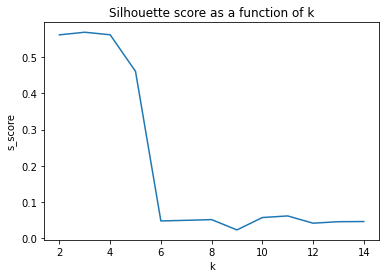

In [54]:
# Plotting the silhouette score as a function of k
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('s_score')
ax1.set_xlabel('k')
ax1.set_title('Silhouette score as a function of k')
plt.plot(k,res)


plt.show()

#### As we have a global maximum for k=3, we choose this value for our analysis

In [57]:
kclusters = 3

joined_grouped_clustering = joined_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(joined_grouped_clustering)
    
    
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = joined_grouped['Neighborhood']

for ind in np.arange(joined_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(joined_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)



In [58]:
neighborhoods_venues_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Battery Park City,Park,Hotel,Gym,Coffee Shop,Memorial Site,Plaza,Shopping Mall,Playground,Pizza Place,Gourmet Shop
1,1,Berczy Park,Coffee Shop,Restaurant,Bakery,Beer Bar,Cheese Shop,Farmers Market,Cocktail Bar,Seafood Restaurant,Tailor Shop,Creperie
2,1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Nightclub,Coffee Shop,Performing Arts Venue,Burrito Place,Stadium,Furniture / Home Store,Bar,Bakery
3,1,"Business reply mail Processing Centre, South C...",Pizza Place,Restaurant,Fast Food Restaurant,Farmers Market,Burrito Place,Butcher,Skate Park,Garden,Garden Center,Light Rail Station
4,1,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Plane,Harbor / Marina,Sculpture Garden,Boat or Ferry,Coffee Shop,Boutique,Airport Terminal,Airport Gate
5,1,Carnegie Hill,Coffee Shop,Café,Yoga Studio,Gym / Fitness Center,Wine Shop,Gym,Italian Restaurant,French Restaurant,Bookstore,Bar
6,1,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Thai Restaurant,Burger Joint,Salad Place,Japanese Restaurant,Bubble Tea Shop,Department Store
7,1,Central Harlem,African Restaurant,Seafood Restaurant,Cosmetics Shop,Bar,French Restaurant,Chinese Restaurant,American Restaurant,Spa,Café,Cafeteria
8,1,Chelsea,Coffee Shop,Art Gallery,American Restaurant,Bakery,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Theater,Bookstore,Hotel
9,1,Chinatown,Chinese Restaurant,Cocktail Bar,Bakery,Dessert Shop,American Restaurant,Spa,Optical Shop,Noodle House,Hotpot Restaurant,Salon / Barbershop


In [60]:
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [59]:
toronto_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [62]:
toronto_data=toronto_data.drop('Postal Code', axis=1)
toronto_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,Downtown Toronto,St. James Town,43.651494,-79.375418
4,East Toronto,The Beaches,43.676357,-79.293031


In [63]:
joined_data = toronto_data.append(manhattan_data)
joined_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,Downtown Toronto,St. James Town,43.651494,-79.375418
4,East Toronto,The Beaches,43.676357,-79.293031


In [64]:
joined_data.shape

(79, 4)

In [65]:
toronto_data.shape

(39, 4)

In [82]:
manhattan_data.shape

(40, 4)

In [83]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitudeNY = location.latitude
longitudeNY = location.longitude

address = 'Toronto, CA'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitudeTO = location.latitude
longitudeTO = location.longitude

In [88]:
joined_merged = joined_data

# merge joined_grouped with joined_data to add latitude/longitude for each neighborhood
joined_merged = joined_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

joined_merged.head() # check the last columns!

# create map
map_clustersNY = folium.Map(location=[latitudeNY, longitudeNY], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(joined_merged['Latitude'], joined_merged['Longitude'], joined_merged['Neighborhood'], joined_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clustersNY)
       
map_clustersNY

In [89]:
# create maps
map_clustersTO = folium.Map(location=[latitudeTO, longitudeTO], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(joined_merged['Latitude'], joined_merged['Longitude'], joined_merged['Neighborhood'], joined_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clustersTO)
       
map_clustersTO

## Results

This is basically useless. Let's try again by analasing all of NY

To be completed in week 2

## Discussion

To be completed in week 2

## Conclusion

To be completed in week 2